<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

import time
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
display.set_matplotlib_formats('svg')

## Import and process data

In [73]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url, sep=',', header=None)
data.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'DISEASE']

# data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?', np.nan).dropna()

data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


In [74]:
# describe the data
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,DISEASE
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


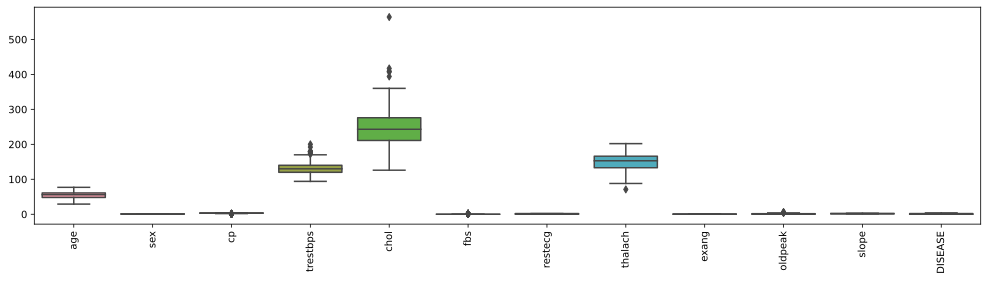

In [77]:
# check the distributions
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    object 
 12  thal      297 non-null    object 
 13  DISEASE   297 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 34.8+ KB


In [81]:
# z-score the non-categorical columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex', 'fbs', 'exang', 'DISEASE'])
cols2zscore

for c in cols2zscore:
    d = pd.to_numeric(data[c])
    data[c] = (d - d.mean()) / d.std(ddof=1)


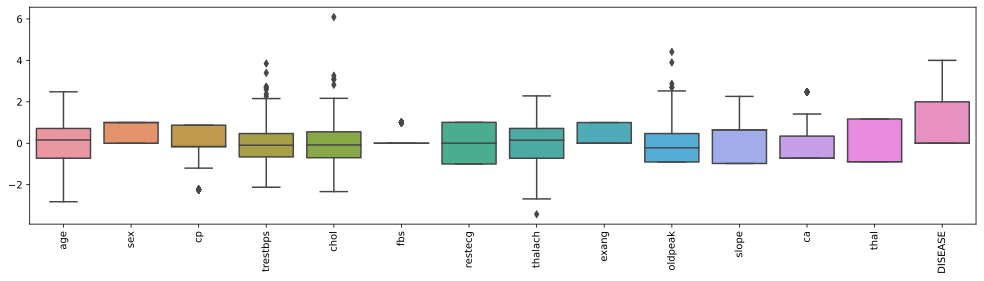

In [82]:
# check the distributions again
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [83]:
data['DISEASE'].value_counts()

0    160
1     54
2     35
3     35
4     13
Name: DISEASE, dtype: int64

In [84]:
data['DISEASE'] = (data['DISEASE'] > 0).astype('int')

In [85]:
data['DISEASE'].value_counts()

0    160
1    137
Name: DISEASE, dtype: int64

In [86]:
labels = data['DISEASE']
data = data.drop(['DISEASE'], axis=1)
print(labels.shape)
print(data.shape)

(297,)
(297, 13)


In [22]:
type(data.values)

numpy.ndarray

In [87]:
labels = labels.values.reshape(-1, 1)

In [88]:
# convert into train test loader
# converting to tensor
dataT = torch.tensor(data.values).float()
labelsT = torch.tensor(labels).float()

# split into train devset test
train_data, devtest_data, train_labels, devtest_labels = train_test_split(dataT, labelsT, train_size=.9, shuffle=True)
dev_data, test_data, dev_labels, test_labels = train_test_split(devtest_data, devtest_labels, train_size=.5, shuffle=True)

# convert to pytorch dataset
train_data = TensorDataset(train_data, train_labels)
dev_data = TensorDataset(dev_data, dev_labels)
test_data = TensorDataset(test_data, test_labels)

# translate to dataloader
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0])
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

print(f'total number of batch {len(train_loader)} with everybatch {batchsize} samples')


total number of batch 16 with everybatch 16 samples


In [89]:
# shapes
print('train: ', train_data.tensors[0].shape)
print('dev: ', dev_data.tensors[0].shape)
print('test: ', test_data.tensors[0].shape)

train:  torch.Size([267, 13])
dev:  torch.Size([15, 13])
test:  torch.Size([15, 13])


## Creating Model

In [90]:
class HDModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(13, 64)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    # forward pass
    def forward(self, x):
        
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.output(x))

        return x

In [91]:
# test the model
net = HDModel()
print(net)
net(torch.randn(10, 13))

HDModel(
  (input): Linear(in_features=13, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)

# A function to train the model

In [102]:
def function2TrainTheModel():

    numepochs = 300

    HDnet = HDModel()

    lossfun = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(HDnet.parameters(), lr=0.0001)

    trainAcc = []
    devAcc = []
    losses = torch.zeros(numepochs)

    for epochi in range(numepochs):
        HDnet.train()

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            
            # forward pass
            yHat = HDnet(X)

            loss = lossfun(yHat, y)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            predictions = (torch.sigmoid(yHat) > .5).float()
            batchAcc.append(100*torch.mean((predictions == y).float()))

        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # eval
        HDnet.eval()
        X, y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = HDnet(X)
        
        predictions = (torch.sigmoid(yHat) > .5).float()
        devAcc.append(100*torch.mean((predictions == y).float()).item())

    # return output
    return trainAcc, devAcc, losses, HDnet

            

In [103]:
# now it's time to train a model
trainAcc, devAcc, losses, HDnet = function2TrainTheModel()

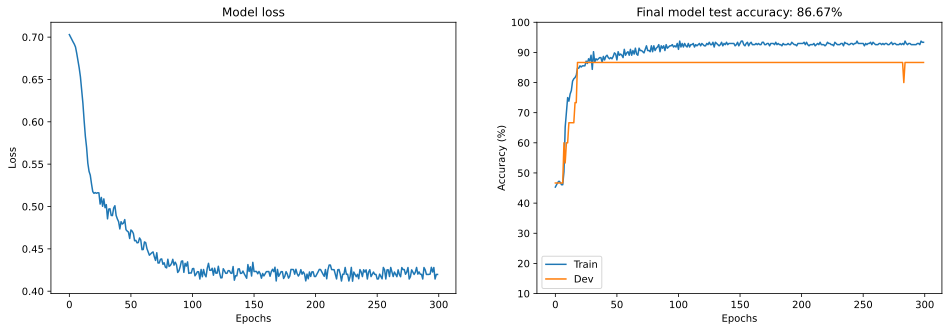

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(devAcc, label='Dev')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {devAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

In [55]:
X, y = next(iter(train_loader))

In [56]:
X

tensor([[1.0284e-01, 1.7730e-03, 3.5461e-03, 2.1277e-01, 5.0355e-01, 0.0000e+00,
         3.5461e-03, 2.8369e-01, 0.0000e+00, 3.1915e-03, 3.5461e-03, 0.0000e+00,
         5.3191e-03],
        [8.5106e-02, 0.0000e+00, 5.3191e-03, 2.3050e-01, 4.8759e-01, 0.0000e+00,
         0.0000e+00, 2.4645e-01, 0.0000e+00, 3.5461e-04, 1.7730e-03, 0.0000e+00,
         5.3191e-03],
        [1.1348e-01, 1.7730e-03, 5.3191e-03, 2.4823e-01, 5.9397e-01, 0.0000e+00,
         0.0000e+00, 2.8014e-01, 0.0000e+00, 0.0000e+00, 1.7730e-03, 0.0000e+00,
         5.3191e-03],
        [1.0638e-01, 1.7730e-03, 7.0922e-03, 2.4823e-01, 5.1950e-01, 0.0000e+00,
         3.5461e-03, 3.0142e-01, 0.0000e+00, 2.1277e-03, 3.5461e-03, 3.5461e-03,
         1.2411e-02],
        [9.3972e-02, 1.7730e-03, 7.0922e-03, 2.5177e-01, 4.0071e-01, 0.0000e+00,
         3.5461e-03, 1.9681e-01, 1.7730e-03, 0.0000e+00, 1.7730e-03, 0.0000e+00,
         1.2411e-02],
        [9.0426e-02, 0.0000e+00, 7.0922e-03, 2.3050e-01, 5.4078e-01, 0.0000e+00,

In [57]:
y

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]])